# Introduction

This workbook fits a Gaussian Process model to the Random and Sobol data. 

In [2]:
import GPy
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

In [3]:
df = pd.read_csv('results/results_clean.csv')
print(df.dtypes)
df.head()


method               object
mean_test_score     float64
var_test_scores     float64
mean_train_score    float64
var_train_scores    float64
basis                object
lag_time              int64
n_components          int64
n_clusters            int64
dtype: object


,method,mean_test_score,var_test_scores,mean_train_score,var_train_scores,basis,lag_time,n_components,n_clusters
0,bayesian,1.365817,0.024526,2.961204,0.000734,close_cont,868,7,216
1,bayesian,1.102779,0.000681,1.986818,0.003915,chi_tor,123,8,719
2,bayesian,1.599413,0.196503,2.996799,0.000002,alpha_angle,528,9,503
3,bayesian,1.921110,0.119855,2.992483,0.000026,all_tor,909,6,245
4,bayesian,1.665484,0.082431,2.997487,0.000004,close-h_cont,228,10,990


Rescale the lag time 

In [4]:
df['lag_time'] *= 0.5

Extract relevant rows and columns

In [5]:
df_rand = df.loc[df['method']=='random', :].loc[:, ['mean_test_score', 'var_test_scores', 
                                                    'basis', 'lag_time', 'n_components', 'n_clusters']]
df_sobl = df.loc[df['method']=='random', :].loc[:, ['mean_test_score', 'var_test_scores', 
                                                    'basis', 'lag_time', 'n_components', 'n_clusters']]

# Build up model

## PPO basis, y ~ n_clusters

In [6]:
ppo_rand_idx = df_rand['basis']=='ppo_tor'
form = 'mean_test_score ~ -1 + n_clusters'
y, x = pt.dmatrices(form, df_rand.loc[ppo_rand_idx, :], return_type='dataframe')

In [7]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(x, y,kernel)
_ = m.optimize_restarts(num_restarts = 10, verbose=False)

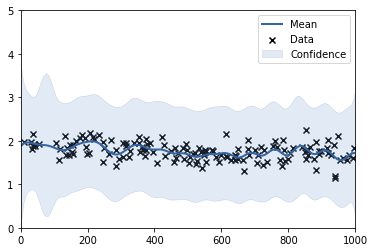

In [8]:
with sns.plotting_context():
    fig, ax = plt.subplots()
    m.plot(ax=ax)
    ax.set_xlim(0, 1000)
    ax.set_ylim(0, 5)

## PPO basis, y ~ n_clusters + lag_time

In [9]:
ppo_rand_idx = df_rand['basis']=='ppo_tor'
form = 'mean_test_score ~ -1 + n_clusters + lag_time'
y, x = pt.dmatrices(form, df_rand.loc[ppo_rand_idx, :], return_type='dataframe')
x_scale = preprocessing.scale(x)

In [10]:
kernel = np.sum([GPy.kern.RBF(input_dim=1, ARD=True, active_dims=[i]) for i in range(2)])
m = GPy.models.GPRegression(x_scale, y,kernel)
_ = m.optimize_restarts(num_restarts = 50, verbose=False)

 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x11ec58d30>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x11ec58fd0>]}

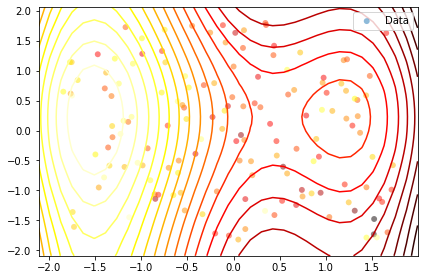

In [11]:
m.plot()


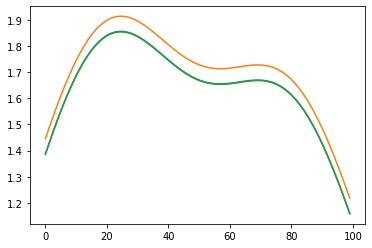

In [12]:
for x2_new in [-2, 0, 2]:
    
    x_new = np.concatenate((np.linspace(-3,3, 100)[:, np.newaxis], x2_new*np.ones(100)[:, np.newaxis]), axis=1)

    mean, var = m.predict(Xnew=x_new)
    plt.plot(mean)


## PPO basis, y ~ n_clusters + lag_time + n_components

## Fit model

In [13]:
ppo_rand_idx = df_rand['basis']=='ppo_tor'
form = 'mean_test_score ~ -1 + n_clusters + lag_time + n_components'
y, x = pt.dmatrices(form, df_rand.loc[ppo_rand_idx, :], return_type='dataframe')
x_scale = preprocessing.scale(x)

In [106]:
kernel = np.sum([GPy.kern.RBF(input_dim=1, ARD=True, active_dims=[i]) for i in range(3)])

m = GPy.models.GPRegression(x_scale, y,kernel)
_ = m.optimize_restarts(num_restarts = 50, verbose=False)

{'dataplot': [<matplotlib.collections.PathCollection at 0x12b3e3b38>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x12b3e3e80>]}

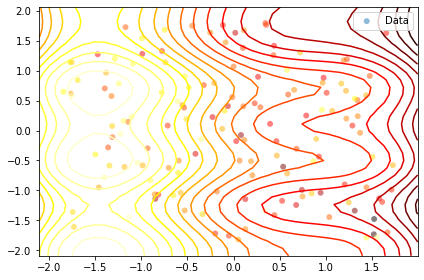

In [107]:
m.plot(fixed_inputs=[(2, -1)])


## Analyse predictions


Text(0.1, 0.8, 'rmse: 1.98,\nll: -83.10')

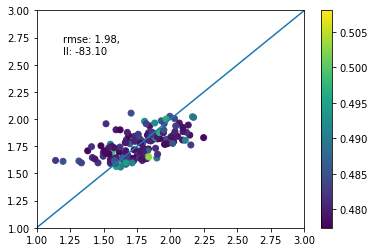

In [157]:
y_pred, var_pred = m.predict(Xnew=x_scale)
rmse = np.sqrt(np.sum((y_pred-y)**2))[0]
ll = m.log_likelihood()[0]

plt.scatter(y, y_pred, c=np.sqrt(var_pred))
plt.colorbar()
plt.ylim(1, 3)
plt.xlim(1,3)
plt.plot(np.linspace(1,3,10), np.linspace(1,3,10))
plt.annotate(s='rmse: {0:4.2f},\nll: {1:4.2f}'.format(rmse, ll), xy=(0.1, 0.8), xycoords='axes fraction')

In [104]:
z = x.join(y).join(pd.DataFrame(y_pred, index=y.index, columns=['y_pred']))

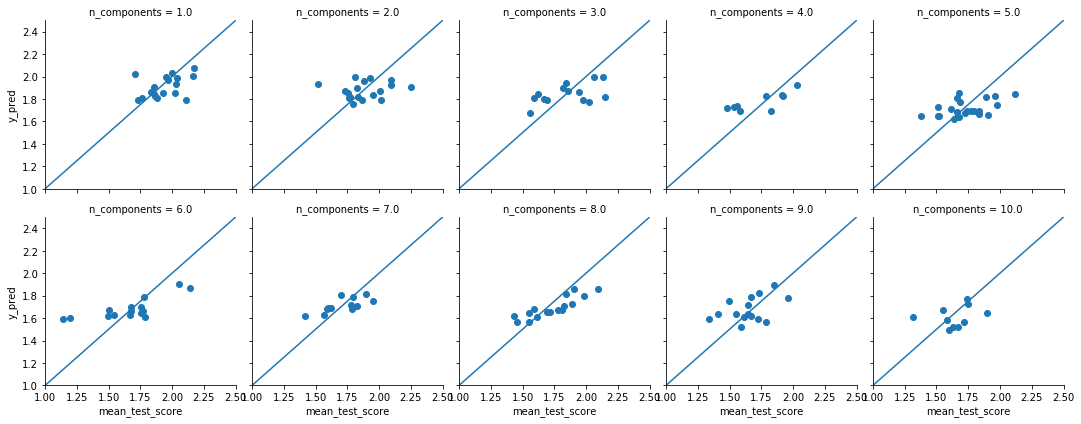

In [105]:
g = sns.FacetGrid(data=z, col='n_components', col_wrap=5)
g.map(plt.scatter, 'mean_test_score', 'y_pred')
g.set(ylim=(1,2.5), xlim=(1, 2.5))
for ax in g.axes.flatten(): 
    ax.plot(np.linspace(1,3,10), np.linspace(1,3,10))

Trying RBF, Exponential, Matern52 and 32 on the above gives the following: 

| Kernel | RMSE | LL |
| ---    | --- | ---| 
| RBF | 1.95 | -82 |
| Exp | 1.62 | -96|
| M52 | 1.97 | -83 |
| M32 | 1.84 | -89 |

## PPO basis, y ~ n_clusters + lag_time + C(n_components)

In [121]:
df_rand.loc[ppo_rand_idx, 'n_components']

3978     7
3979     2
3980    10
3981     2
3982     5
        ..
4122     5
4123     1
4124     8
4125     1
4126     8
Name: n_components, Length: 149, dtype: int64

In [128]:
form = 'mean_test_score ~ -1 + n_clusters + lag_time + C(n_components)'

y, x = pt.dmatrices(form, df_rand.loc[ppo_rand_idx, :], return_type='dataframe')

x_scale = preprocessing.scale(x)

In [129]:
x.head()

,C(n_components)[1],C(n_components)[2],C(n_components)[3],C(n_components)[4],C(n_components)[5],C(n_components)[6],C(n_components)[7],C(n_components)[8],C(n_components)[9],C(n_components)[10],n_clusters,lag_time
3978,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,465.0,15.5
3979,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,719.0,429.0
3980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,427.0,59.5
3981,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,891.0,283.5
3982,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,542.0,240.5


In [153]:
ker1 = np.sum([GPy.kern.Matern52(input_dim=1, ARD=True, active_dims=[i]) for i in range(10, 12)])
ker2 = np.product([GPy.kern.RBF(input_dim=1, ARD=True, active_dims=[i]) for i in range(0, 10)])
kernel = ker1 + ker2
m = GPy.models.GPRegression(x_scale, y,kernel)
_ = m.optimize_restarts(num_restarts = 50, verbose=False)

Text(0.1, 0.8, 'rmse: 1.99,\nll: -84.38')

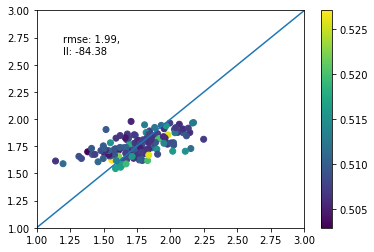

In [154]:
y_pred, var_pred = m.predict(Xnew=x_scale)

rmse = np.sqrt(np.sum((y_pred-y)**2))[0]

ll = m.log_likelihood()[0]

plt.scatter(y, y_pred, c=np.sqrt(var_pred))
plt.colorbar()
plt.ylim(1, 3)
plt.xlim(1,3)
plt.plot(np.linspace(1,3,10), np.linspace(1,3,10))
plt.annotate(s='rmse: {0:4.2f},\nll: {1:4.2f}'.format(rmse, ll), xy=(0.1, 0.8), xycoords='axes fraction')

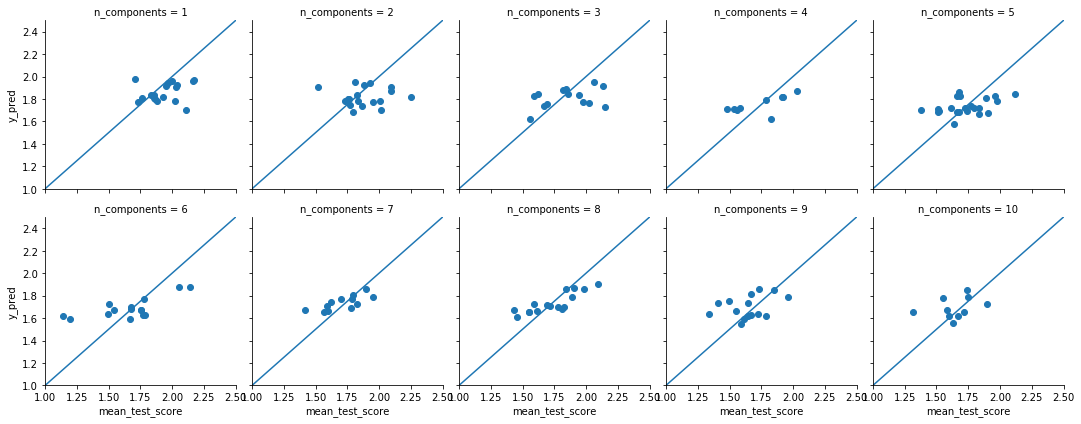

In [155]:
z = df_rand.loc[ppo_rand_idx, ['mean_test_score', 'n_components', 'lag_time', 'n_clusters']].join(pd.DataFrame(y_pred, index=y.index, columns=['y_pred']))
g = sns.FacetGrid(data=z, col='n_components', col_wrap=5)
g.map(plt.scatter, 'mean_test_score', 'y_pred')
g.set(ylim=(1,2.5), xlim=(1, 2.5))
for ax in g.axes.flatten(): 
    ax.plot(np.linspace(1,3,10), np.linspace(1,3,10))

Trying RBF, Exponential, Matern52 and 32 on the above with RBF product on components gives: 

| Kernel | RMSE | LL |
| ---    | --- | ---| 
| RBF | 1.98 | -81 |
| Exp | 1.76 |  -88 |
| M52 | 1.99 | -84 |

## RBF + Bias

In [159]:
ppo_rand_idx = df_rand['basis']=='ppo_tor'
form = 'mean_test_score ~ -1 + n_clusters + lag_time + n_components'
y, x = pt.dmatrices(form, df_rand.loc[ppo_rand_idx, :], return_type='dataframe')
x_scale = preprocessing.scale(x)

kernel = np.sum([GPy.kern.RBF(input_dim=1, ARD=True, active_dims=[i]) for i in range(3)])
kernel = kernel + GPy.kern.Bias(3) + GPy.kern.Linear(3)

m = GPy.models.GPRegression(x_scale, y,kernel)
_ = m.optimize_restarts(num_restarts = 50, verbose=False)

Text(0.1, 0.8, 'rmse: 1.99,\nll: -85.70')

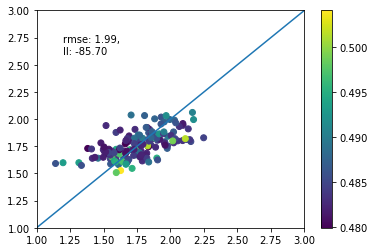

In [160]:
y_pred, var_pred = m.predict(Xnew=x_scale)
rmse = np.sqrt(np.sum((y_pred-y)**2))[0]
ll = m.log_likelihood()[0]

plt.scatter(y, y_pred, c=np.sqrt(var_pred))
plt.colorbar()
plt.ylim(1, 3)
plt.xlim(1,3)
plt.plot(np.linspace(1,3,10), np.linspace(1,3,10))
plt.annotate(s='rmse: {0:4.2f},\nll: {1:4.2f}'.format(rmse, ll), xy=(0.1, 0.8), xycoords='axes fraction')

## RBF + Exp for n_components

In [162]:
ppo_rand_idx = df_rand['basis']=='ppo_tor'
form = 'mean_test_score ~ -1 + n_clusters + lag_time + n_components'
y, x = pt.dmatrices(form, df_rand.loc[ppo_rand_idx, :], return_type='dataframe')
x_scale = preprocessing.scale(x)

kernel = np.sum([GPy.kern.RBF(input_dim=1, ARD=True, active_dims=[i]) for i in range(2)])
kernel = kernel + GPy.kern.Exponential(input_dim=1, ARD=True, active_dims=[2])

m = GPy.models.GPRegression(x_scale, y,kernel)
_ = m.optimize_restarts(num_restarts = 50, verbose=False)

y_pred, var_pred = m.predict(Xnew=x_scale)
rmse = np.sqrt(np.sum((y_pred-y)**2))[0]
ll = m.log_likelihood()[0]

plt.scatter(y, y_pred, c=np.sqrt(var_pred))
plt.colorbar()
plt.ylim(1, 3)
plt.xlim(1,3)
plt.plot(np.linspace(1,3,10), np.linspace(1,3,10))
plt.annotate(s='rmse: {0:4.2f},\nll: {1:4.2f}'.format(rmse, ll), xy=(0.1, 0.8), xycoords='axes fraction')

## Exp + RBF for n_components

Text(0.1, 0.8, 'rmse: 1.79,\nll: -83.15')

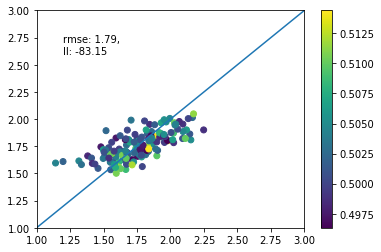

In [166]:
ppo_rand_idx = df_rand['basis']=='ppo_tor'
form = 'mean_test_score ~ -1 + n_clusters + lag_time + n_components'
y, x = pt.dmatrices(form, df_rand.loc[ppo_rand_idx, :], return_type='dataframe')
x_scale = preprocessing.scale(x)

kernel = np.sum([GPy.kern.Exponential(input_dim=1, ARD=True, active_dims=[i]) for i in range(2)])
kernel = kernel + GPy.kern.RBF(input_dim=1, ARD=True, active_dims=[2])

m = GPy.models.GPRegression(x_scale, y,kernel)
_ = m.optimize_restarts(num_restarts = 50, verbose=False)

y_pred, var_pred = m.predict(Xnew=x_scale)
rmse = np.sqrt(np.sum((y_pred-y)**2))[0]
ll = m.log_likelihood()[0]

plt.scatter(y, y_pred, c=np.sqrt(var_pred))
plt.colorbar()
plt.ylim(1, 3)
plt.xlim(1,3)
plt.plot(np.linspace(1,3,10), np.linspace(1,3,10))
plt.annotate(s='rmse: {0:4.2f},\nll: {1:4.2f}'.format(rmse, ll), xy=(0.1, 0.8), xycoords='axes fraction')